In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader
from src.news_providers.tradingview_provider import TradingViewProvider

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

In [2]:
coin = "ETH"

cutoff = get_current_datetime()
str(cutoff)

'2024-04-27 12:12:11.227820'

In [3]:
day_history = get_day_history(coin)
week_history = get_week_history(coin)
month_history = get_month_history(coin)
year_history = get_year_history(coin)

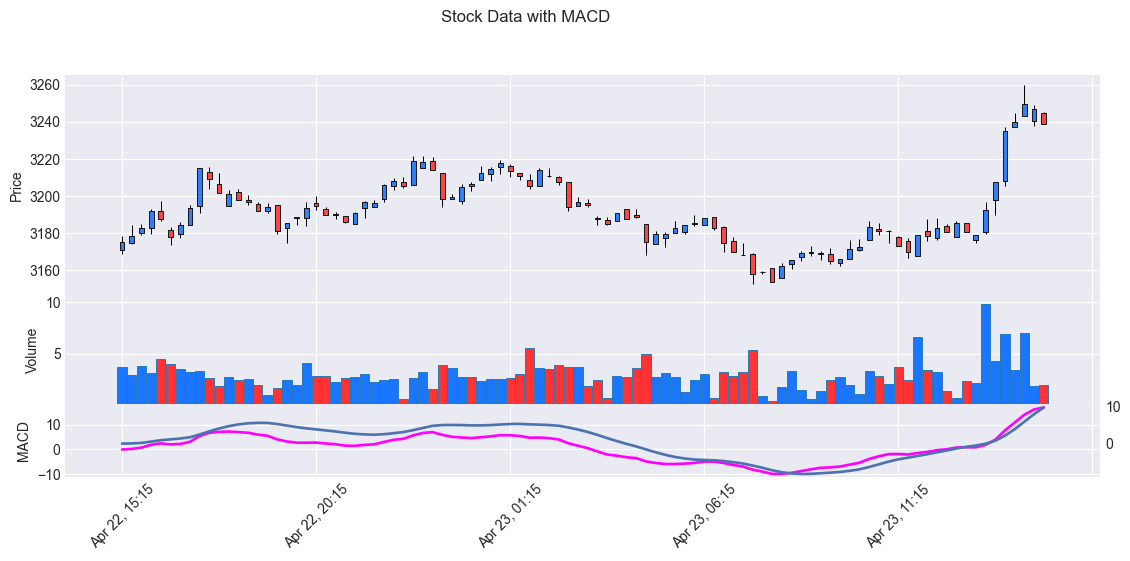

In [162]:
make_candlebars(day_history)

In [163]:
napi = TradingViewProvider()
trading_agent = SupervisorMarginTrader()
filtering_agent = NewsFilteringAgent()

In [164]:
news = napi.get_news(coin)
news

[{'source': 'the_block',
  'title': 'Binance to list Renzo token EZ on Launchpool as part of token distribution plan',
  'description': 'The crypto exchange giant Binance intends to list EZ, a token from the liquid restaking protocol Renzo, as part of the token\'s distribution plan.Binance will first incorporate the token into its Launchpool today at 8 p.m. ET (April 24 at 00:00 UTC) before listing the token on April 30 at 8 a.m. ET (12:00 UTC). In the six days before its listing, users can stake the exchange\'s token BNB and stablecoin FDUSD into separate pools to farm the token, according to a company release.After listing, individuals can trade with the EZ/BTC, EZ/USDT, EZ/BNB and EZ/FDUSD, among other trading pairs.The EZ tokens in the Binance Launchpool comprise 2.5% of the total token supply, which was also announced Tuesday. Ten percent will go to airdrops, 31.65% to investors and advisors, 20% to the team, 20% to the DAO treasury, 13.44% to Renzo\'s foundation and 2.5% to liqui

In [165]:
filtered_news = filtering_agent.filter_news(coin, news[:30])
json.loads(filtered_news)

{'description': "Ethereum's market sentiment has been influenced primarily by positive developments surrounding its technology and adoption, despite some fluctuations in trading volumes. Notable events include a massive purchasing activity by a crypto whale, suspected to be Tron founder Justin Sun, who bought over $405 million worth of ETH, indicating strong confidence in Ethereum's long-term value. This event has spurred a bullish sentiment among other investors. Ethereum's technological strides were also highlighted with the proposed Deneb-Cancun upgrade, which significantly impacted Ethereum’s network fundamentals and is expected to support its price in the long term. However, there were concerns about ETH's trading volume, which has shown signs of decline, potentially signaling a short-term caution among traders.",
 'sentiment': 'mixed',
 'sentiment_description': 'The sentiment surrounding Ethereum is mixed. While the strong purchase activities by prominent whales like Justin Sun s

In [166]:
balance = {coin: 0, "USDT": 1000}
operations_history = []

[{'role': 'system', 'content': "You are professional futures trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format.\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                \n                Your ultimate goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day. Current price: 3238.87'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last week'}, {'type': 'image_url', 'image_url': {'url': '', 'deta
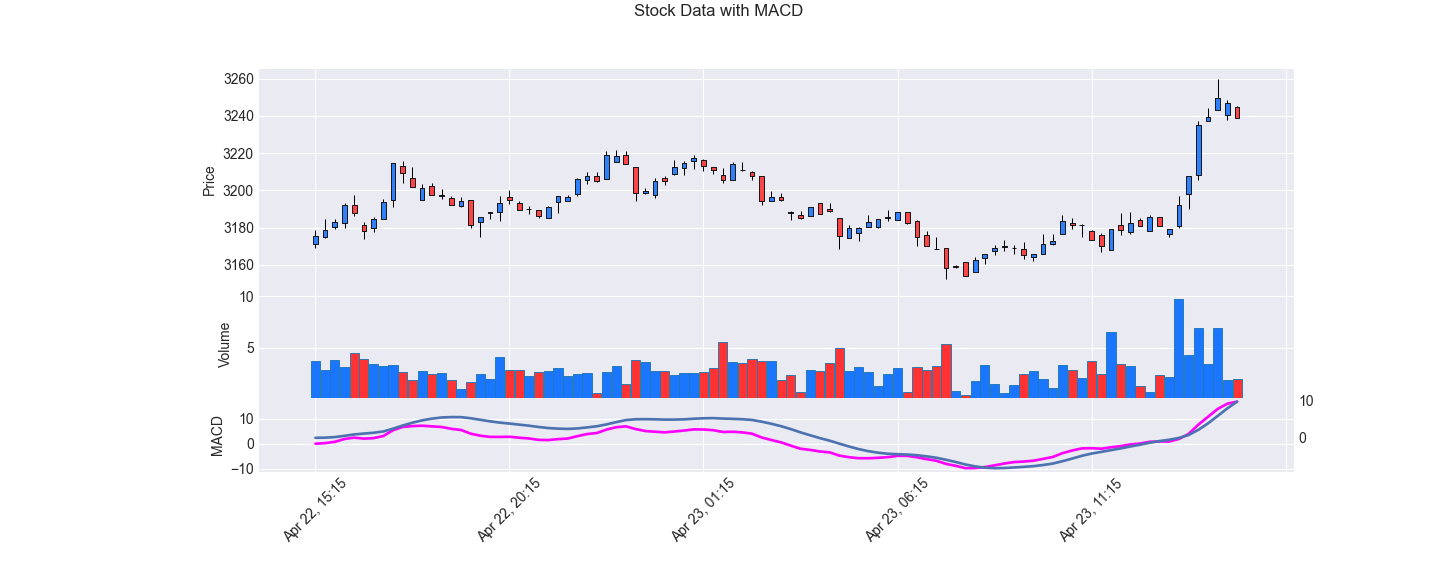
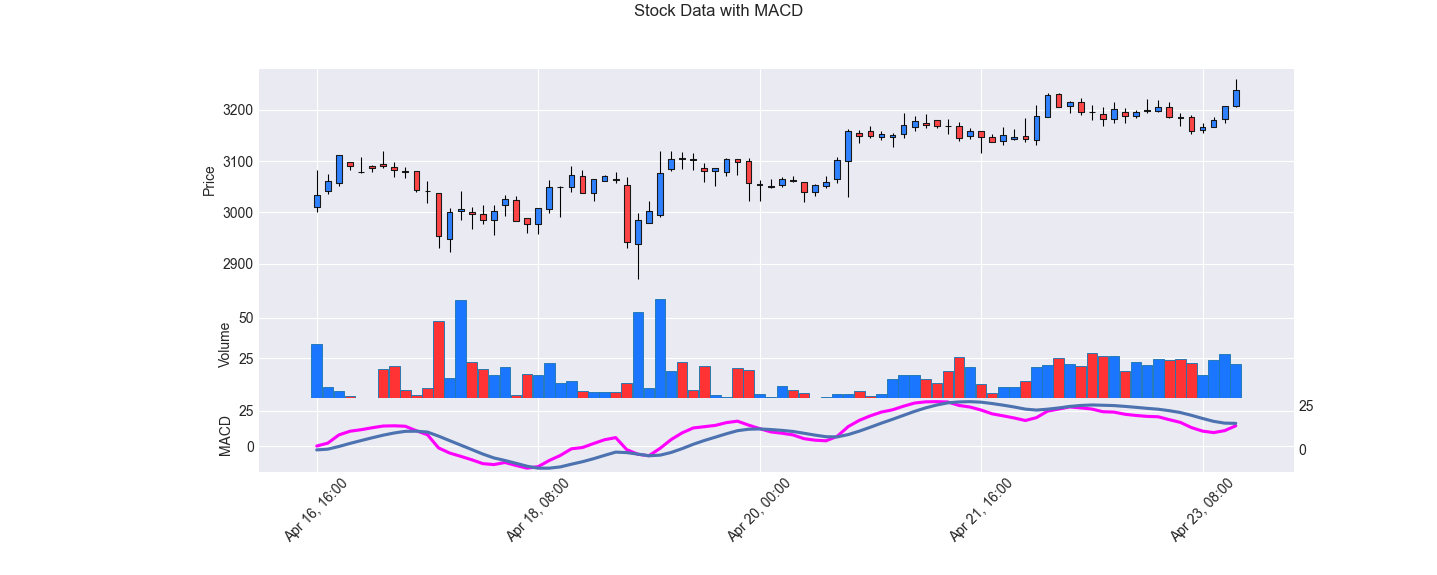
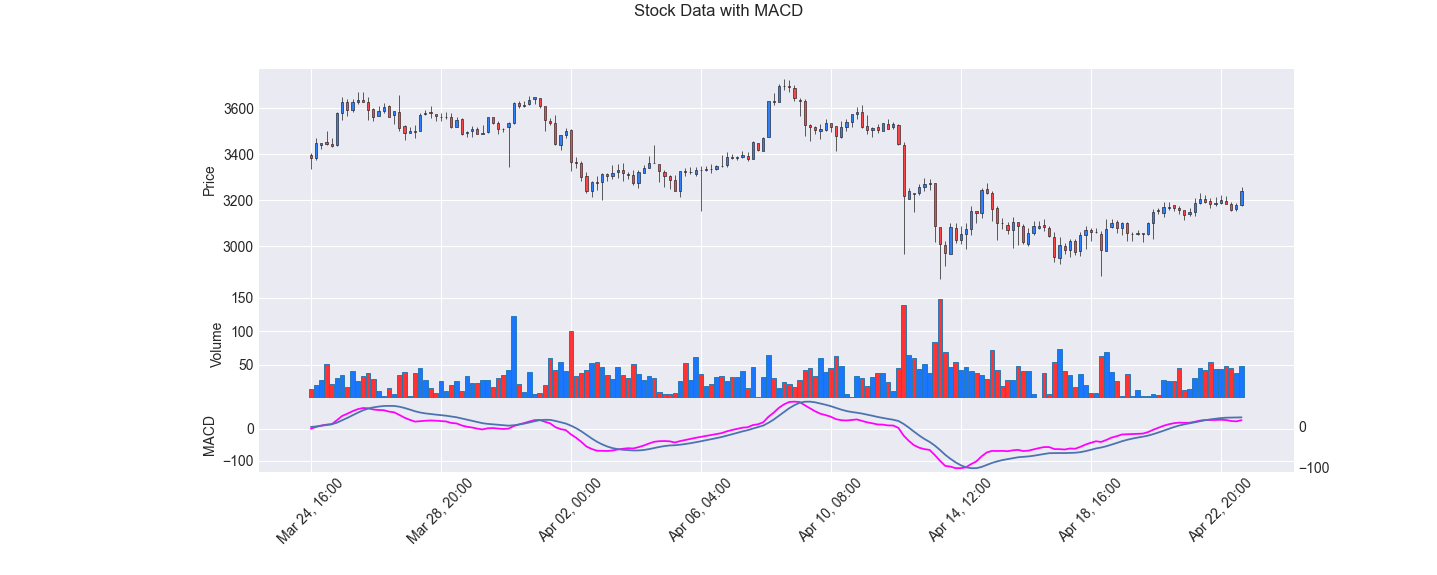

{'strategy_evaluation': 'The decision to hold positions makes sense given the mixed market signals and the recent increase in price without sufficient volume support. Diverse sentiment from the news also supports a cautious strategy rather than aggressive trading at this point. The goal is to preserve capital in the face of uncertainty and potential short-term volatility.',
 'calculations_evaluation': 'The calculations provided are simplistic estimations based on potential price targets for buying and selling actions. They correctly reflect a balanced perspective on risk vs reward with a conservative approach of maintaining the wealth in uncertain market condition.',
 'changes_description': 'No changes are required in the strategy as the hold decision aligns well with current market conditions and protects against potential downturns while the market sentiment remains mixed.',
 'trend_analysis': 'Considering the recent data, where a significant purchase by a known crypto whale indicate

In [167]:
predict, _ = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    #year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    leverage="1x",
    verbose=True,
)

result = json.loads(predict)
result